# AlexNet Training Exploration

## Overview

- Splits the training images to train and val dataset
- Takes a pretrained AlexNet on ImageNet1k and replaces the last FC layer with one that outputs 1 value [0,1]
- Trains the model for 100 epochs using:
    - Batch size: 64
    - Loss: Binary Cross Entropy Loss
    - Optimizer: Adam
- Metrics are shown through Tensorboard

The loss stablizes after around 10 epochs so I chose to test using checkpoint 20 of the model

In [2]:
from torch.utils.tensorboard import SummaryWriter

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import AlexNet_Weights
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
from timeit import default_timer as timer
import os

## Hyperparamters

In [3]:
batch_size = 64
epochs = 100
num_classes = 2
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

# Set seeds
torch.manual_seed(1)
torch.cuda.manual_seed(1)
generator = torch.Generator().manual_seed(1)

# Create output folder
if not os.path.exists("models"):
    os.makedirs("models")

# Tensorboard writer
writer = SummaryWriter()

## Load Data

In [5]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # needed for alexNet
])

In [6]:
dataset = ImageFolder("dataset/train/", transform=transform)
train_data, val_data = random_split(dataset, [0.8, 0.2], generator=generator)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

## Load Model

In [7]:
model = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)

In [8]:
# Freeze all layers
# Repalce final FC layer to output desired classes

for param in model.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(4096, 1)

model.to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1, bias=True)
)

## Training Loop

In [9]:
def train(dataloader, model, loss_fn, optimizer, device, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss, correct = 0, 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X).squeeze()
        loss = loss_fn(pred, y.float())
        total_loss += loss
        
        class_pred = (pred >= 0.5).int()
        correct += (class_pred == y).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    total_loss /= num_batches
    correct /= size
    
    writer.add_scalar('Loss/train', total_loss, epoch)
    writer.add_scalar('Accuracy/train', correct, epoch)

    return model

def test(dataloader, model, loss_fn, device, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X).squeeze()
            test_loss += loss_fn(pred, y.float()).item()

            class_pred = (pred >= 0.5).int()
            correct += (class_pred == y).sum().item()
            y_true.append(y)
            y_pred.append(pred)

    test_loss /= num_batches
    correct /= size

    np_y_true = torch.cat(y_true).cpu().numpy()
    np_y_pred = (torch.cat(y_pred).cpu().numpy() >= 0.5).astype(int)
    
    precision, recall, f1, _ = precision_recall_fscore_support(np_y_true, np_y_pred, average='binary')

    writer.add_scalar('Loss/val', test_loss, epoch)
    writer.add_scalar('Accuracy/val', correct, epoch)
    writer.add_scalar('Precision/val', precision, epoch)
    writer.add_scalar('Recall/val', recall, epoch)
    writer.add_scalar('f1/val', f1, epoch)

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} ")
    print(f" Precision: {precision:>8f}, Recall: {recall:>8f}, f1: {f1:>8f} \n")

In [11]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, device, t)
    test(val_dataloader, model, loss_fn, device, t)

    if t % 5 == 0:
        print(f"Saving Checkpoint epoch: {t}")
        torch.save(model, f"models/alexnet-{t}.pt")
    
print("Done!")

Epoch 1
-------------------------------
loss: 0.297609  [   64/40110]
loss: 0.137872  [ 6464/40110]
loss: 0.171866  [12864/40110]
loss: 0.195911  [19264/40110]
loss: 0.199593  [25664/40110]
loss: 0.217819  [32064/40110]
loss: 0.240318  [38464/40110]
Test Error: 
 Accuracy: 95.1%, Avg loss: 0.139151 
 Precision: 0.922525, Recall: 0.957320, f1: 0.939601 

Saving Checkpoint epoch: 0
Epoch 2
-------------------------------
loss: 0.094730  [   64/40110]
loss: 0.281667  [ 6464/40110]
loss: 0.228001  [12864/40110]
loss: 0.231983  [19264/40110]
loss: 0.115617  [25664/40110]
loss: 0.146536  [32064/40110]
loss: 0.111591  [38464/40110]
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.134895 
 Precision: 0.929964, Recall: 0.958809, f1: 0.944166 

Epoch 3
-------------------------------
loss: 0.178695  [   64/40110]
loss: 0.085618  [ 6464/40110]
loss: 0.131573  [12864/40110]
loss: 0.107443  [19264/40110]
loss: 0.087353  [25664/40110]
loss: 0.177764  [32064/40110]
loss: 0.157685  [38464/40110]
Test Error:

## Test Inference

In [15]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # needed for alexNet
])

test_dataset = ImageFolder("dataset/test/", test_transform)
test_dataloader = DataLoader(test_dataset, shuffle=False)
model = torch.load("models/alexnet-20.pt")

In [32]:
def inference(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.to(device)
    model.eval()
    test_loss, correct = 0, 0
    y_true = []
    y_pred = []
    exec_times = []
    with torch.no_grad():
        for X, y in dataloader:
            start_time = timer()
            X, y = X.to(device), y.to(device)
            pred = model(X).squeeze(1)
            end_time = timer()
            test_loss += loss_fn(pred, y.float()).item()

            class_pred = (pred >= 0.5).int()
            correct += (class_pred == y).sum().item()
            y_true.append(y)
            y_pred.append(pred)
            exec_times.append(end_time - start_time)

    test_loss /= num_batches
    correct /= size

    np_y_true = torch.cat(y_true).cpu().numpy()
    np_y_pred = (torch.cat(y_pred).cpu().numpy() >= 0.5).astype(int)
    
    precision, recall, f1, _ = precision_recall_fscore_support(np_y_true, np_y_pred, average='binary')
    avg_exec_time = np.mean(exec_times)

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} ")
    print(f" Precision: {precision:>8f}, Recall: {recall:>8f}, f1: {f1:>8f} Exec Time: {avg_exec_time:>8f}\n")

In [33]:
# GPU Inference on RTX 3060 Ti

inference(test_dataloader, model, loss_fn, "gpu")

Test Error: 
 Accuracy: 97.1%, Avg loss: 0.087312 
 Precision: 0.960069, Recall: 0.970077, f1: 0.965047 Exec Time: 0.002260



In [34]:
# CPU Inference on Ryzen 3600
inference(test_dataloader, model, loss_fn, "cpu")

Test Error: 
 Accuracy: 97.1%, Avg loss: 0.087311 
 Precision: 0.960069, Recall: 0.970077, f1: 0.965047 Exec Time: 0.025343



## Plots and Graphs
You don't need to run anything above this to create the graphs. Download the metrics data folder from box for the csvs

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

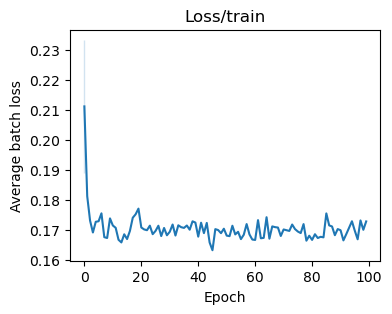

In [45]:
df = pd.read_csv("metrics/alexnet-loss-train.csv")

plt.subplots(figsize=(4, 3))
ax = sns.lineplot(x="Step", y="Value", data=df)
ax.set(xlabel='Epoch',
       ylabel='Average batch loss',
       title='Loss/train')

# plt.savefig("alexnet-loss-train.png")

plt.show()

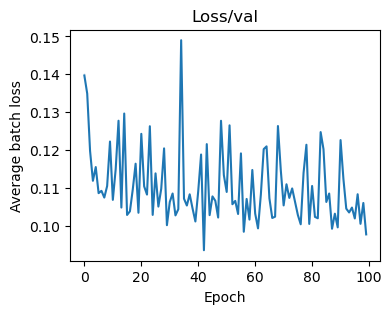

In [47]:
df = pd.read_csv("metrics/alexnet-loss-val.csv")

plt.subplots(figsize=(4, 3))
ax = sns.lineplot(x="Step", y="Value", data=df)
ax.set(xlabel='Epoch',
       ylabel='Average batch loss',
       title='Loss/val')

# plt.savefig("alexnet-loss-val.png")

plt.show()

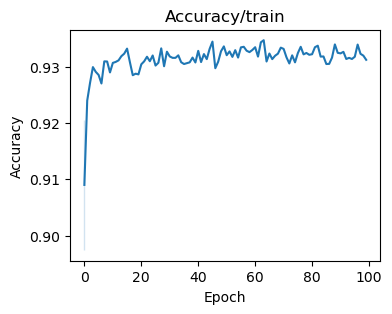

In [48]:
df = pd.read_csv("metrics/alexnet-acc-train.csv")

plt.subplots(figsize=(4, 3))
ax = sns.lineplot(x="Step", y="Value", data=df)
ax.set(xlabel='Epoch',
       ylabel='Accuracy',
       title='Accuracy/train')

# plt.savefig("alexnet-acc-train.png")

plt.show()

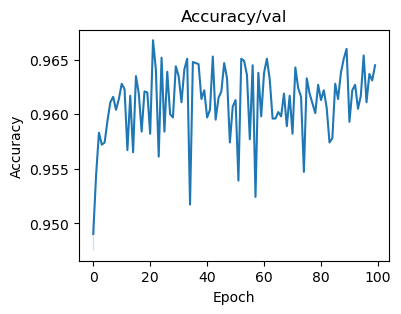

In [49]:
df = pd.read_csv("metrics/alexnet-acc-val.csv")

plt.subplots(figsize=(4, 3))
ax = sns.lineplot(x="Step", y="Value", data=df)
ax.set(xlabel='Epoch',
       ylabel='Accuracy',
       title='Accuracy/val')

# plt.savefig("alexnet-acc-val.png")

plt.show()

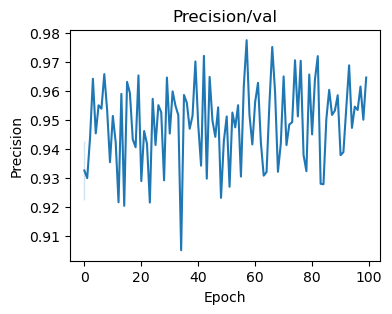

In [51]:
df = pd.read_csv("metrics/alexnet-precision-val.csv")

plt.subplots(figsize=(4, 3))
ax = sns.lineplot(x="Step", y="Value", data=df)
ax.set(xlabel='Epoch',
       ylabel='Precision',
       title='Precision/val')

# plt.savefig("alexnet-precision-val.png")

plt.show()

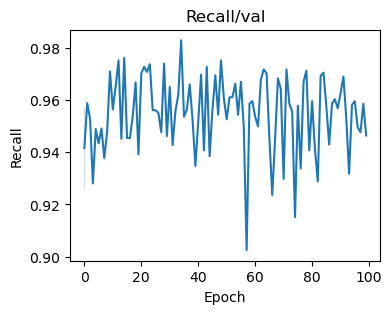

In [52]:
df = pd.read_csv("metrics/alexnet-recall-val.csv")

plt.subplots(figsize=(4, 3))
ax = sns.lineplot(x="Step", y="Value", data=df)
ax.set(xlabel='Epoch',
       ylabel='Recall',
       title='Recall/val')

# plt.savefig("alexnet-recall-val.png")

plt.show()

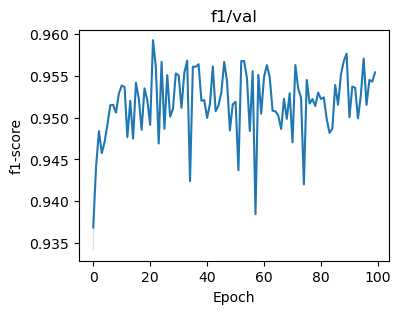

In [53]:
df = pd.read_csv("metrics/alexnet-f1-val.csv")

plt.subplots(figsize=(4, 3))
ax = sns.lineplot(x="Step", y="Value", data=df)
ax.set(xlabel='Epoch',
       ylabel='f1-score',
       title='f1/val')

# plt.savefig("alexnet-f1-val.png")

plt.show()